<a href="https://colab.research.google.com/github/nildodnjunior/mestrado_comp_ifes_ml/blob/master/backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from scipy.special import expit
from sklearn.preprocessing import label_binarize
from abc import ABC, abstractmethod
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPClassifier
import warnings
from sklearn.exceptions import ConvergenceWarning

In [5]:
def sign(a):
    return (a>0)*2 - 1

def criaDataset(n=100, centros=3):
    X, y = make_blobs(n_samples=n, centers=centros, cluster_std=0.2)
    return X, y

def criaDatasetDificil(n=100, centros=10):
    X, y = make_blobs(n_samples=n, centers=centros, cluster_std=0.1)
    y = sign(np.array(y%2, dtype=int))
    return X, y

def plotDataset(X, y):
    plt.xlabel('x1')
    plt.ylabel('x2')
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', alpha=0.3)

def defineAxes(X):
    offset = 0.5
    min1, max1 = X[:,0].min(), X[:,0].max()
    min2, max2 = X[:,1].min(), X[:,1].max()
    return [min1-offset, max1+offset, min2-offset, max2+offset]

def plotPredictions(clf, X):
    axes = defineAxes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, aplha=0.2)

def include_bias(X):
    bias = np.ones((X.shape[0], 1))
    Xb = np.concatenate((bias, X), axis=1)
    return Xb

###Funções de ativação

In [127]:
class ActivationFunction(ABC):
  @abstractmethod
  def forward(a):
    pass
  @abstractmethod
  def backward(a):
    pass

class TanH(ActivationFunction):
  def forward(self, a):
    return expit(a)*2-1
  def backward(self, a):
    return (1 - np.square(self.forward(a)))

class Sigmoid(ActivationFunction):
  def forward(self, a):
    return expit(a)
  def backward(self, a):
    return self.forward(a) * (1 - self.forward(a))

#Implementação da função de ativação ReLU:
class ReLU(ActivationFunction):
    def forward(self, a):
        return np.maximum(a, np.zeros(shape=a.shape))
    def backward(self, a):
        return (a > 0) * 1

In [135]:
"""
Função de backpropagation. Cada item da lista do parâmetro n_hidden corresponde à quantidade
de neurônios daquela camada da rede neural. O parâmetro activation contém as funções
de ativação que serão aplicadas a cada camada da rede e deve ter o mesmo shape
de n_hidden; aceita as funções TanH, Sigmoid e ReLU.
"""
class Backpropagation(BaseEstimator, ClassifierMixin):
    def __init__(self, max_iter=1000, learning_rate=0.005, n_hidden=[2],
                 activation=[TanH()]):
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.n_hidden = n_hidden
        self.activation = activation

    def forward(self, X):
        self.A = []
        self.Z = []
        AUX = X.copy()
        for W in self.Ws:
            self.A.append(include_bias(AUX))
            self.Z.append(self.A[-1] @ W)
            AUX = self.activation[-1].forward(self.Z[-1])
        return AUX

    def backward(self, X, y, ypred):
        grads = []
        output_delta = y - ypred
        grads.insert(0, self.A[-1].T @ output_delta)
        for i in range(len(self.Ws)-1, 0, -1):
            tanh_grad = self.activation[i-1].backward(self.Z[i-1])
            input_delta = (output_delta @ self.Ws[i][1:,:].T)*tanh_grad
            grads.insert(0, self.A[i-1].T @ input_delta)
            output_delta = input_delta.copy()
        for i in range(len(self.Ws)-1, -1, -1):
            self.Ws[i] += grads[i] * self.learning_rate

    def encode_labels(self, y):
        self.labels = list(set(y))
        return label_binarize(y, classes=self.labels)*2 - 1

    def fit(self, X, y):
        yhot = self.encode_labels(y)
        self.Ws = []
        previous_output = X.shape[1]
        for layer_size in self.n_hidden:
            self.Ws.append(np.random.uniform(-1, 1, size=(previous_output+1, layer_size)))
            previous_output = self.Ws[-1].shape[1]
        self.Ws.append(np.random.uniform(-1, 1, size=(previous_output+1, yhot.shape[1])))
        for _ in range(self.max_iter):
            ypred = self.forward(X)
            self.backward(X, yhot, ypred)

    def predict(self, X):
        a = self.forward(X)
        if len(self.labels) <= 2:
            idx = np.array(a>0, dtype=int).reshape(-1,)
        else:
            idx = np.argmax(a, axis=1)
        ypred = np.array([self.labels[i] for i in idx])
        return ypred

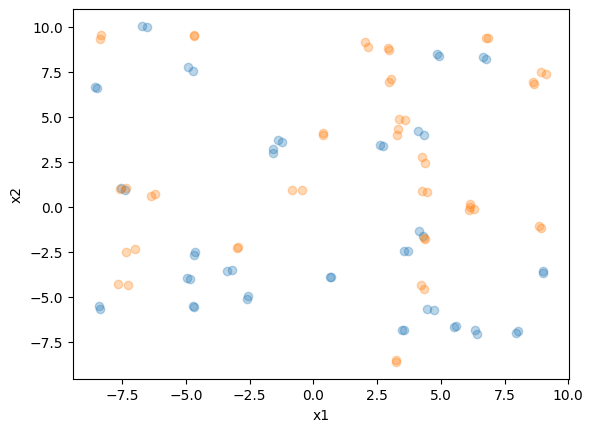

In [55]:
X, y = criaDatasetDificil(centros=50)
plotDataset(X, y)

###Criando uma rede neural criada neste notebook e uma criada pelo Scikit-learn com os mesmos parâmetros e mostrando os resultados.
Como exemplo, foram criadas redes neurais com 3 camadas, com 100, 100 e 50 neurônios cada, usando a função de ativação TanH em cada camada.

Em média, de acordo com o resultado encontrado, o MLP do scikit-learn geralmente encontra scores um maiores para esse caso. Porém, foi necessário aumentar o número máximo de iterações, senão encontrava resultados piores. Foi utilizado o valor max_iter=1000.

In [151]:
scores = cross_validate(Backpropagation(n_hidden=[100, 100, 50], activation=[TanH(), TanH(), TanH()]), X, y)
print("Scores da rede criada (Tanh):")
print(scores['test_score'], np.mean(scores['test_score']))

scores_sklearn = cross_validate(MLPClassifier(hidden_layer_sizes=[100, 100, 50],
                                              activation='tanh', learning_rate_init=0.005,
                                              max_iter=1000), X, y)
print('Scores do MLP do scikit-learn (Tanh):')
print(scores_sklearn['test_score'], np.mean(scores_sklearn['test_score']))

scores = cross_validate(Backpropagation(n_hidden=[100, 100, 50], activation=[Sigmoid(), Sigmoid(), Sigmoid()]), X, y)
print("\nScores da rede criada (Sigmoid):")
print(scores['test_score'], np.mean(scores['test_score']))

scores_sklearn = cross_validate(MLPClassifier(hidden_layer_sizes=[100, 100, 50],
                                              activation='logistic', learning_rate_init=0.005,
                                              max_iter=1000), X, y)
print('\nScores do MLP do scikit-learn (Sigmoid):')
print(scores_sklearn['test_score'], np.mean(scores_sklearn['test_score']))

Scores da rede criada (Tanh):
[0.7  0.8  0.65 0.85 0.9 ] 0.78
Scores do MLP do scikit-learn (Tanh):
[0.75 0.75 0.7  0.95 0.95] 0.8200000000000001

Scores da rede criada (Sigmoid):
[0.75 0.6  0.6  0.65 0.8 ] 0.68

Scores do MLP do scikit-learn (Sigmoid):
[0.75 0.75 0.7  0.95 0.9 ] 0.8100000000000002
